In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
!nvidia-smi

Mon Feb 24 19:11:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.86.15              Driver Version: 570.86.15      CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100 80GB PCIe          On  |   00000000:17:00.0 Off |                    0 |
| N/A   45C    P0             59W /  300W |       1MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [3]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor, AutoModel 
from qwen_vl_utils import process_vision_info

import torch
import json
import random
import io
import ast
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageColor

import Levenshtein
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

/gpfs/projects/CascanteBonillaGroup/jmurrugarral/anaconda3/envs/py10-QWEN/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [4]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [5]:


# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-7B-Instruct", torch_dtype="auto", device_map="auto"
)

# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-7B-Instruct")


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

In [6]:
#directory = "/home/jmurrugarral/VLM-Privacy"
#folder_path = "/home/jmurrugarral/datasets/BIV-Priv_Image/support_images"

directory = "/gpfs/projects/CascanteBonillaGroup/jmurrugarral/QWEN"
folder_path = "/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images"

In [7]:
from collections import Counter

additional_colors = [colorname for (colorname, colorcode) in ImageColor.colormap.items()]

def pil_to_opencv(img):
    return cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

def opencv_to_pil(img):
    return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def plot_bounding_boxes(im, bounding_boxes, input_width, input_height, image_width, image_height, json=False):
    """
    Plots bounding boxes on an image with markers for each a name, using PIL, normalized coordinates, and different colors.

    Args:
        img_path: The path to the image file.
        bounding_boxes: A list of bounding boxes containing the name of the object
         and their positions in normalized [y1 x1 y2 x2] format.
    """

    # Load the image
    img = im
    width, height = img.size
    # Create a drawing object
    draw = ImageDraw.Draw(img)

    # Define a list of colors
    colors = ['red','green','blue','yellow','orange','pink','purple','brown','gray','beige','turquoise','cyan','magenta','lime','navy','maroon',
    'teal','olive','coral','lavender','violet','gold','silver',] + additional_colors

    if json == False:

        # Parsing out the markdown fencing
        bounding_boxes = parse_json(bounding_boxes)

        #font = ImageFont.truetype("NotoSansCJK-Regular.ttc", size=14)

        try:
          json_output = ast.literal_eval(bounding_boxes)
        except Exception as e:
          end_idx = bounding_boxes.rfind('"}') + len('"}')
          truncated_text = bounding_boxes[:end_idx] + "]"
          json_output = ast.literal_eval(truncated_text)
    else:
        #json_output = ast.literal_eval(bounding_boxes)
        json_output = bounding_boxes

    bboxes = np.zeros((int(len(json_output)),4))
    labels = []

    # Iterate over the bounding boxes
    for i, bounding_box in enumerate(json_output):
      # Select a color from the list
      color = colors[i % len(colors)]

      bboxes[i,:] = np.array([int(bounding_box["bbox_2d"][0]/input_width * image_width),
                              int(bounding_box["bbox_2d"][1]/input_height * image_height),
                              int(bounding_box["bbox_2d"][2]/input_width * image_width),
                              int(bounding_box["bbox_2d"][3]/input_height * image_height)])



      # Convert normalized coordinates to absolute coordinates
      abs_y1 = int(bounding_box["bbox_2d"][1]/input_height * height)
      abs_x1 = int(bounding_box["bbox_2d"][0]/input_width * width)
      abs_y2 = int(bounding_box["bbox_2d"][3]/input_height * height)
      abs_x2 = int(bounding_box["bbox_2d"][2]/input_width * width)

      if abs_x1 > abs_x2:
        abs_x1, abs_x2 = abs_x2, abs_x1
        bboxes[i,0], bboxes[i,2] = bboxes[i,2], bboxes[i,0]


      if abs_y1 > abs_y2:
        abs_y1, abs_y2 = abs_y2, abs_y1
        bboxes[i,1], bboxes[i,3] = bboxes[i,3], bboxes[i,1]

      #bboxes[i,:] = np.array([abs_x1, abs_y1, abs_x2, abs_y2])

      # Draw the bounding box
      draw.rectangle(((abs_x1, abs_y1), (abs_x2, abs_y2)), outline=color, width=4)

      # Draw the text
      if "label" in bounding_box:
        draw.text((abs_x1 + 8, abs_y1 + 6), bounding_box["label"], fill=color)#, font=font)

      if "text_content" in bounding_box:
        labels.append(bounding_box["text_content"])

    # Display the image
    #img.show()

    return img, bboxes, labels

# @title Parsing JSON output
def parse_json(json_output):
    # Parsing out the markdown fencing
    lines = json_output.splitlines()
    for i, line in enumerate(lines):
        if line == "```json":
            json_output = "\n".join(lines[i+1:])  # Remove everything before "```json"
            json_output = json_output.split("```")[0]  # Remove everything after the closing "```"
            break  # Exit the loop once "```json" is found
    return json_output

def locate_private_content(img_full_path, prompt, temperature = 1, top_p = 0.8, grounding = True):

    max_new_tokens=1024
    messages = [
        {
            "role": "system",
            "content": "You are a helpful assistant"
        },
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": prompt
                },
                {
                  "image": img_full_path
                }
            ]
        }
    ]

    if isinstance(img_full_path, Image.Image):
        image = img_full_path
    else:
        image = Image.open(img_full_path)
        
    text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = processor(text=[text], images=[image], padding=True, return_tensors="pt").to('cuda')



    output_ids = model.generate(**inputs, max_new_tokens=1024)#, temperature= temperature, top_p = top_p)
    generated_ids = [output_ids[len(input_ids):] for input_ids, output_ids in zip(inputs.input_ids, output_ids)]
    output_text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)

    input_height = inputs['image_grid_thw'][0][1]*14
    input_width = inputs['image_grid_thw'][0][2]*14
    response = output_text[0]
    #print(response)

    if grounding == True:
        image_width, image_height = image.size
        image.thumbnail([1000, 1000], Image.Resampling.LANCZOS)

        if 'bbox_2d' in response:
            image, bboxes, labels = plot_bounding_boxes(image,response,input_width,input_height,image_width, image_height)
        else:
            image = image
            bboxes = None
            labels = None

    else:
        image  = image
        bboxes = None
        labels = None

    return response, image, bboxes, labels

def get_pseudo_detections(img_full_path, threshold_conf):
    #ans, img = locate_private_content(img_full_path, "Spotting all the text in the image with line-level, and output in JSON format.", temperature = 1, top_p=0.8)#, show_results = False)
    #ans, img = locate_private_content(img_full_path, "Describe the text with labels, and output in JSON format", temperature = 1, top_p=0.8)#, show_results = False)

    #ans, img = locate_private_content(img_full_path, "Which is the angle orientation of the file?.", temperature = 1, top_p=0.8)#, show_results = False)

    ans, img, bboxes, labels = locate_private_content(img_full_path, "Spotting all the text and provide a label in the image with line-level, and output in JSON format.", temperature = 1, top_p=0.8)#, show_results = False)

    return img, bboxes, labels

def warp_bboxes(bboxes, matrix):

    coord      = np.zeros((4,2))
    n          = bboxes.shape[0]

    for i in range(n):

        detection = bboxes[i,:]

        coord[0,:] = matrix @ np.array([detection[0], detection[1], 1])
        coord[1,:] = matrix @ np.array([detection[0], detection[3], 1])
        coord[2,:] = matrix @ np.array([detection[2], detection[1], 1])
        coord[3,:] = matrix @ np.array([detection[2], detection[3], 1])

        bboxes[i,:] = np.array([np.min(coord[:,0]),np.min(coord[:,1]),np.max(coord[:,0]),np.max(coord[:,1])])

    return bboxes

def warp_bboxes_homography(bboxes, matrix):

    coord      = np.zeros((4,2))
    n          = bboxes.shape[0]

    for i in range(n):

        detection = bboxes[i,:]

        h1 = matrix @ np.array([detection[0], detection[1], 1])
        h2 = matrix @ np.array([detection[0], detection[3], 1])
        h3 = matrix @ np.array([detection[2], detection[1], 1])
        h4 = matrix @ np.array([detection[2], detection[3], 1])

        print(h1)
        
        coord[0,:] = h1[0:2]/h1[2]
        coord[1,:] = h2[0:2]/h2[2]
        coord[2,:] = h3[0:2]/h3[2]
        coord[3,:] = h4[0:2]/h4[2]
        
        bboxes[i,:] = np.array([np.min(coord[:,0]),np.min(coord[:,1]),np.max(coord[:,0]),np.max(coord[:,1])])

    return bboxes

def rotate_image(image, angle, output_path):

    # Get image dimensions
    (h, w) = image.shape[:2]

    # Compute the center of the image
    center = (w // 2, h // 2)

    # Get the rotation matrix
    M = cv2.getRotationMatrix2D(center, angle, 1.0)

    # Compute the new bounding dimensions
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    new_w = int((h * sin) + (w * cos))
    new_h = int((h * cos) + (w * sin))

    # Adjust the rotation matrix for translation
    M[0, 2] += (new_w / 2) - center[0]
    M[1, 2] += (new_h / 2) - center[1]

    if angle == 0:
        rotated = image
    elif angle == 90:
        rotated = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
    elif angle == 180:
        rotated = cv2.rotate(image, cv2.ROTATE_180)
    elif angle == 270:
        rotated = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
    else:
        rotated = cv2.warpAffine(image, M, (new_w, new_h))

    M   = np.append(M, [[0,0,1]],axis=0)
    M_I = np.linalg.inv(M).astype(np.float32)

    
    
    # Save the rotated image
    cv2.imwrite(output_path, rotated)

    return M_I[0:2,:], opencv_to_pil(rotated.astype(np.uint8))

def jaccard_multiset(str1, str2):
    # Convert words to frequency counts
    counter1 = Counter(str1)
    counter2 = Counter(str2)
    
    # Compute intersection and union based on frequency counts
    intersection = sum(min(counter1[char], counter2[char]) for char in counter1 & counter2)
    union = sum(max(counter1[char], counter2[char]) for char in counter1 | counter2)
    
    return intersection / union if union != 0 else 0

def nms(bboxes, scores, labels, iou_threshold=0.5):
    """
    Perform Non-Maximum Suppression (NMS) on bounding boxes.
    
    Parameters:
    - bboxes: numpy array of shape (N, 4), where each row is (x1, y1, x2, y2)
    - scores: numpy array of shape (N,), confidence scores of each bbox
    - iou_threshold: float, IoU threshold for suppression
    
    Returns:
    - indices of the remaining bounding boxes after NMS
    """
    if len(bboxes) == 0:
        return []

    # Convert to numpy arrays if not already
    bboxes = np.array(bboxes)
    scores = np.array(scores)

    # Compute area of each bounding box
    areas = (bboxes[:, 2] - bboxes[:, 0]) * (bboxes[:, 3] - bboxes[:, 1])

    # Sort boxes by confidence score in descending order
    order = np.argsort(scores)[::-1]

    keep = []
    
    while order.size > 0:
        # Pick the bbox with the highest score and remove it from order
        idx = order[0]
        keep.append(idx)

        # Compute IoU between the highest-score box and remaining boxes
        x1 = np.maximum(bboxes[idx, 0], bboxes[order[1:], 0])
        y1 = np.maximum(bboxes[idx, 1], bboxes[order[1:], 1])
        x2 = np.minimum(bboxes[idx, 2], bboxes[order[1:], 2])
        y2 = np.minimum(bboxes[idx, 3], bboxes[order[1:], 3])

        # Compute intersection area
        inter_w = np.maximum(0, x2 - x1)
        inter_h = np.maximum(0, y2 - y1)
        intersection = inter_w * inter_h

        # Compute IoU
        iou = intersection / (areas[idx] + areas[order[1:]] - intersection)

        # Keep boxes with IoU less than the threshold
        order = order[1:][iou < iou_threshold]

    return bboxes[keep,:], [labels[k] for k in keep ]#labels[np.array(keep),:]
    
def rotation_fine_grained(image, method):

    original_ans, _, _, _ = locate_private_content(image.copy(), "Please output only the text content from the image without any additional descriptions or formatting.", temperature = 1, top_p=0.8, grounding = False)

    rotations = np.arange(0,360,10)
    max_distancia, min_distancia = -1e9, 1e9
    new_bboxes = np.empty((0,4))#np.array([])

    new_image = None

    
    for rotation in [0,90,180,270]:#[0, 45, 90, 135, 180, 225, 270, 315]:#rotations:


        image_file = 'rotated.jpg'
        matrix, rotated_image = rotate_image(pil_to_opencv(image), rotation, image_file)
        img_full_path = os.path.join(directory, image_file)
        image2, bboxes, labels = get_pseudo_detections(img_full_path, 0.8)

        plt.imshow(image2)
        plt.show()
        #image2, bboxes, labels = get_pseudo_detections(rotated_image, 0.8) # DO NOT ACTIVATE
        
        temp_bboxes = warp_bboxes(bboxes, matrix)
        temp_bboxes, labels = nms(temp_bboxes , np.ones(temp_bboxes.shape[0]), labels, iou_threshold=0.5)
        
        if method == 5:

            distancia = 0
            cv_image  = pil_to_opencv(image)
            new_image = np.zeros(cv_image.shape).astype(np.uint8)
            
            for id_box, (box, label) in enumerate(zip(temp_bboxes, labels)):
                
                new_image = np.zeros(cv_image.shape).astype(np.uint8)
                new_image[int(box[1]):int(box[3]),int(box[0]):int(box[2])] = cv_image[int(box[1]):int(box[3]),int(box[0]):int(box[2])]
                
                ans, _, _,_  = locate_private_content(opencv_to_pil(new_image), "Please output only the text content from the image without any additional descriptions or formatting.", temperature = 1, top_p=0.8, grounding = False)
                distancia = jaccard_multiset(ans, label) 
                
                if distancia >=0.5:
                    new_bboxes = np.append(new_bboxes, temp_bboxes[id_box, :][np.newaxis, :], axis=0)

    return new_image, new_bboxes


['/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/848.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/938.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/545.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/53.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/730.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/498.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/1166.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/225.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/130.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/662.jpeg', '/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/support_images/10.jpeg', '/gpfs/projects/CascanteBonillaGroup/datase

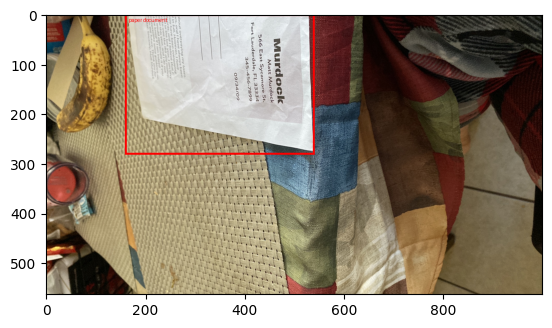

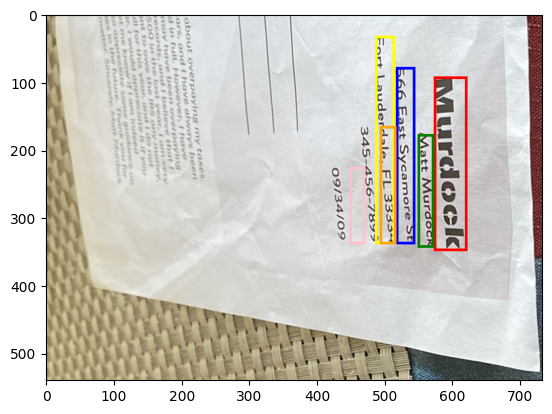

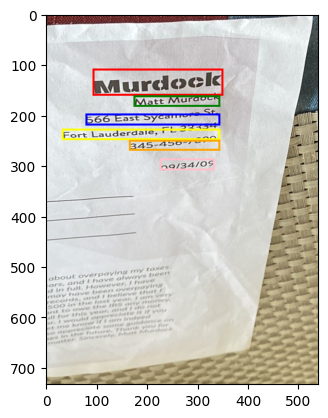

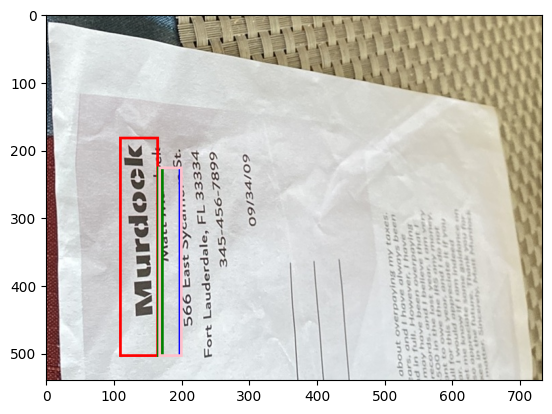

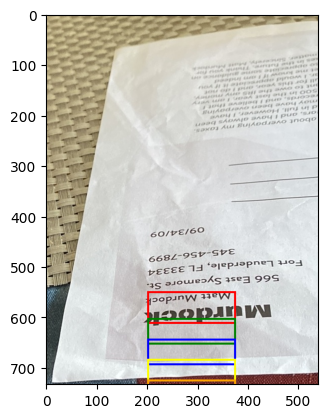

[[791.5  32.  820.5 339. ]
 [822.5  78.  850.5 339. ]
 [854.5 177.  878.5 344. ]
 [878.5  92.  927.5 349. ]
 [729.5 225.  752.5 333. ]
 [768.5 164.  789.5 344. ]
 [789.5  31.  811.5 344. ]
 [818.5  78.  841.5 344. ]
 [855.5 173.  877.5 344. ]
 [877.5  92.  930.5 350. ]
 [865.5  35.  874.5 315. ]
 [872.5  35.  930.5 359. ]
 [854.5 165.  918.5 340. ]]


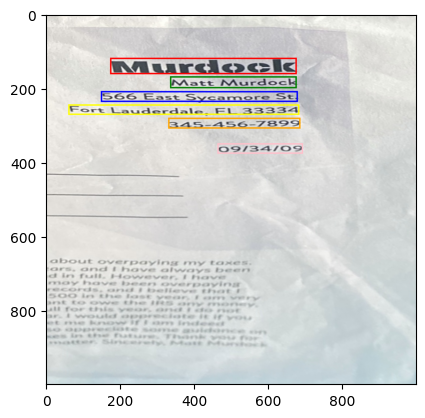

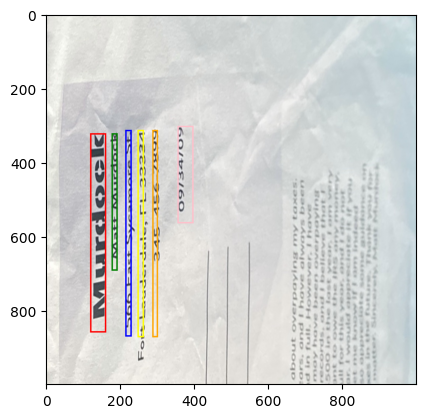

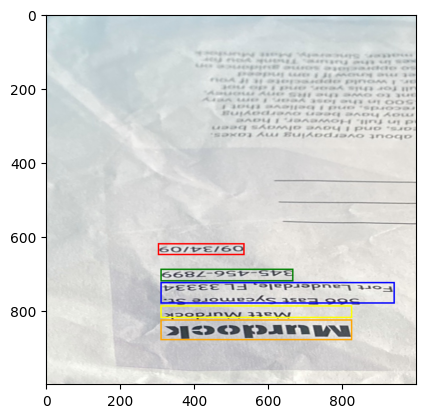

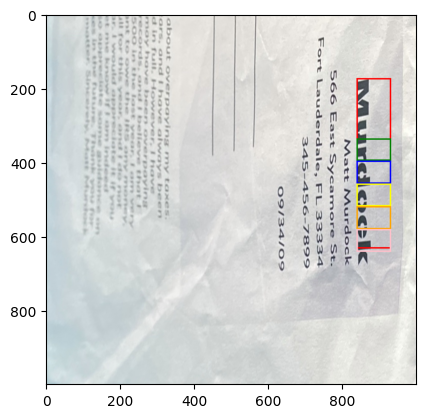

[365.45661325 195.38158029   0.86313948]
[393.01725201 139.25684988   0.83795774]
[395.66725615  25.31942725   0.81277342]
[419.24928674  62.45458722   0.80908605]
[450.66830809 141.36680216   0.81034653]
[466.80284043  73.00434858   0.78815839]
[360.74668352 183.56584758   0.86295341]
[377.56305511  53.59278768   0.82751259]
[398.04830844  53.59278768   0.81754422]
[415.06558114  54.43676859   0.8094404 ]
[444.42198435 129.55106944   0.81090809]
[464.36122063  59.07866359   0.78642604]
[466.2907091   73.00434858   0.7884076 ]
[408.86573212  24.47544634   0.80617388]
[394.15845338 140.10083079   0.83757941]
[365.5150826  195.80357075   0.86319953]
[492.4094071   73.00434858   0.77569792]
[[403.52825858 224.54624311 432.10778862 333.93146651]
 [447.43521096 164.7649702  481.60738834 337.33913133]
 [465.17472894  30.88671883 508.2689862  339.48116369]
 [495.39505006  76.50812639 535.47949182 341.19245046]
 [530.696371   172.7522121  566.46360883 343.83617575]
 [555.94536474  91.35551559 

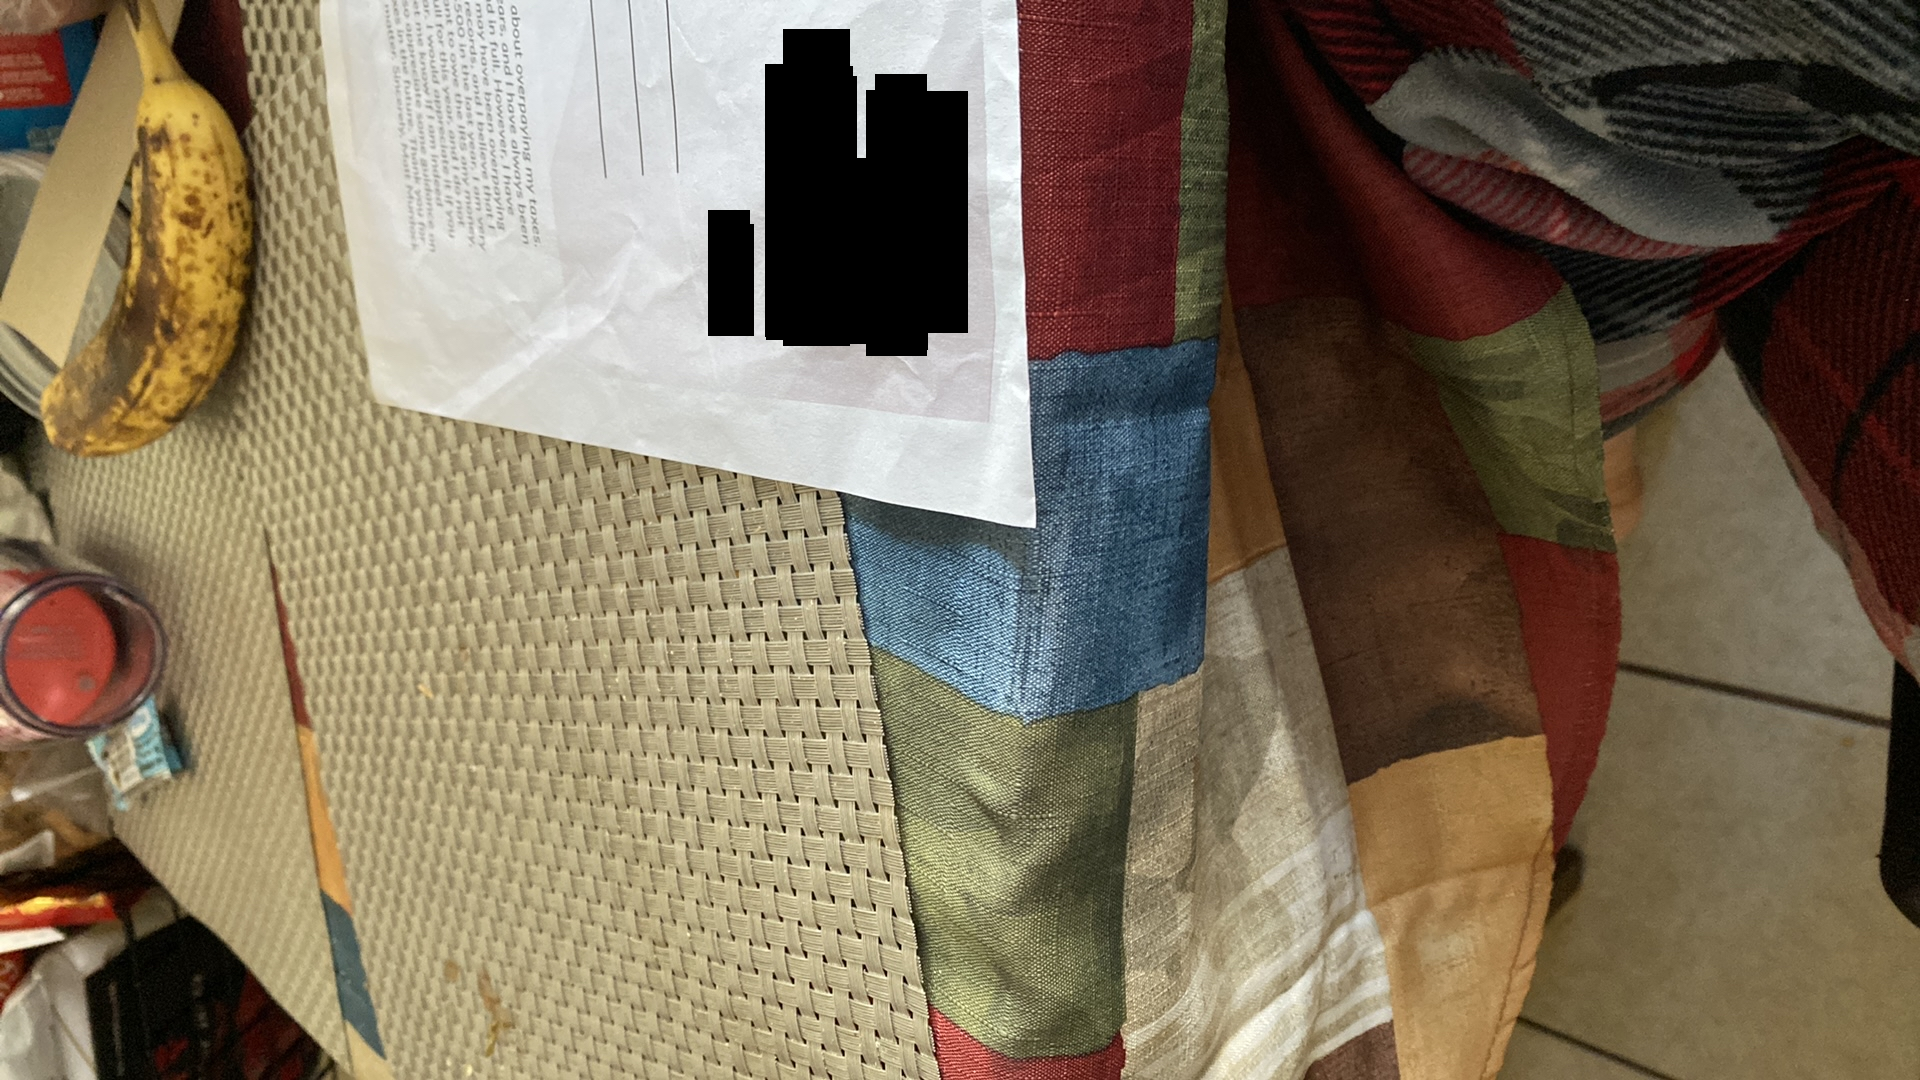

In [8]:
import glob
import time
from IPython.display import display            

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))  
    
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)


def set_zero_outside_mask(image, mask):
    """Sets pixel values outside the mask to 0."""

    # Ensure image and mask have compatible shapes
    if image.shape[:2] != mask.shape:
        raise ValueError("Image and mask must have the same height and width.")

    # Create a copy of the image to avoid modifying the original
    masked_image = image.copy()

    # Set values outside mask to 0
    masked_image[~mask] = 0

    return masked_image

#folder_path = "/home/jmurrugarral/datasets/BIV-Priv_Image/support_images"

#folder_path = "/gpfs/projects/CascanteBonillaGroup/datasets/BIV-Priv_Image/query_images"

# List all files (non-recursively)
files = glob.glob(folder_path + "/*")
print(files)
files = [files[1]]#[files[1],files[2],files[3],files[4], files[5], files[6],files[7], files[8]]

mask_generator = SamAutomaticMaskGenerator(sam)
predictor = SamPredictor(sam)

method = 5
for ind, file in enumerate(files):

   #ans, img, bboxes = locate_private_content(file, "Locate paper document in the image, and output in JSON format.", temperature = 1, top_p=0.8)#, show_results = False)    
    image = Image.open(file)
    ans, img, bboxes, _ = locate_private_content(image.copy(), "Locate paper document in the image, and output in JSON format.", temperature = 1, top_p=0.8)#, show_results = False)


    
    plt.imshow(img)
    plt.show()
    
    if bboxes is not None:

        crop_x1,crop_y1,crop_x2,crop_y2  = int(bboxes[0][0]), int(bboxes[0][1]), int(bboxes[0][2]), int(bboxes[0][3])
        crop_image = image.copy().crop([crop_x1,crop_y1,crop_x2,crop_y2])
        boxes = None
        w, h = crop_image.size
        if w > 28 and h > 28:
            
            _, boxes = rotation_fine_grained(crop_image, method) 
            boxes[:,0] += crop_x1
            boxes[:,1] += crop_y1
            boxes[:,2] += crop_x1
            boxes[:,3] += crop_y1

        predictor.set_image(pil_to_opencv(image))
        bounding_boxes = np.array([bboxes[0][0],bboxes[0][1],bboxes[0][2],bboxes[0][3]])
        masks, _, _ = predictor.predict(point_coords=None, point_labels=None, box=bounding_boxes[None,:], multimask_output=False)

        print(boxes)
        
        if True:
            
            y,x = np.where(masks[0]==True)
            crop_x1,crop_y1,crop_x2,crop_y2  = int(np.min(x)), int(np.min(y)), int(np.max(x)), int(np.max(y))
            crop_image = image.copy().crop([crop_x1,crop_y1,crop_x2,crop_y2])
            masks = masks[0][crop_y1:crop_y2,crop_x1:crop_x2]
            
            thresh = (masks*255).astype(np.uint8)#['segmentation'].astype(np.uint8)
            contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
            #cnt = np.vstack(contours)  # Stack all contours into a single array

            cnt = sorted_contours[0] 
            epsilon = 0.02 * cv2.arcLength(cnt, True)
            corners = cv2.approxPolyDP(cnt, epsilon, True)
            
            #for corner in corners:
            #    cv2.circle(img, tuple(corner[0]), 10, (0, 0, 255), -1)
            #rect = cv2.minAreaRect(cnt)
            #box = cv2.boxPoints(rect)
            #box = box.astype(int)
            #img = cv2.polylines(img, [box], 1, (255,0,0), 2)

            src_points = np.array(corners).reshape(-1,2)
            if len(corners) != 4:
                continue
            
            dst_points = np.array([[0, 1000], [1000, 1000],[1000, 0],[0, 0],], dtype=np.float32)
            H, status  = cv2.findHomography(src_points, dst_points, cv2.RANSAC)
            height, width, channels = (1000, 1000, 3)
            warped_img = cv2.warpPerspective(np.array(crop_image), H, (width, height))

            H_I = np.linalg.inv(H).astype(np.float32)
            _, boxes   = rotation_fine_grained(opencv_to_pil(warped_img), method)
            boxes      = warp_bboxes_homography(boxes, H_I)
            
            print(boxes)   
            boxes[:,0] += crop_x1
            boxes[:,1] += crop_y1
            boxes[:,2] += crop_x1
            boxes[:,3] += crop_y1
        
        if boxes is None:

            image = pil_to_opencv(image)
            image[masks[0]] = [0,0,0]

            index = str(ind)
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.show()
            cv2.imwrite('output/result_0_'+index.zfill(3)+'.png', image)        
            
        else:

            draw = ImageDraw.Draw(image)
            for box in boxes:
                draw.rectangle([int(box[0]),int(box[1]),int(box[2]),int(box[3])], fill=(0, 0, 0))  # Negro para imágenes RGB
            index = str(ind)
            display(image)                
            image.save('output/result_0_'+index.zfill(3)+'.png')
        
        #if len(corners) != 4:
        #    continue
            
        #dst_points = np.array([  
        #    [0, 1000],
        #    [1000, 1000],
        #    [1000, 0],
        #    [0, 0],
        #], dtype=np.float32)


        # Compute the homography matrix
        #H, status = cv2.findHomography(src_points, dst_points, cv2.RANSAC)

        #print("Homography Matrix:")
        #print(H)

        # Warp the source image to align with the destination image
        #height, width, channels = (1000, 1000, 3)
        #warped_img = cv2.warpPerspective(np.array(image), H, (width, height))

        #plt.imshow(warped_img)
        #plt.show()
        

        #cv2.imwrite('masked_himage.jpg', warped_img)

        #image_file = 'masked_himage.jpg'
        #img_full_path = os.path.join(directory, image_file)
        #image2, bboxes, labels = get_pseudo_detections(image_file, img_full_path, 0.8);

        
        #plt.imshow(image2)
        #plt.show()
 

        #end_time = time.time()
        #print(f"One Image, Time: {end_time - start_time:.6f} seconds")        